## Imports


In [1]:
import numpy as np
import pickle
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch.nn import functional as F
from tqdm.auto import tqdm
from PIL import Image
from MyDataset import MyDataset
from torch.utils.data import Dataset
from torch.optim import lr_scheduler

%matplotlib inline

In [2]:
model = models.resnet18(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
fc_features = model.fc.in_features
#修改类别为9
model.fc = nn.Linear(fc_features, 3)
  #(conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [4]:
print(model)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Transform raw data

In [5]:
pre_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomCrop(200),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

### Load Data

In [6]:
train_dataset = MyDataset("./train",pre_transform)
val_dataset = MyDataset("./validate",val_transform)

In [7]:
print("train data length: %d  valid data length % d"%(len(train_dataset),len(val_dataset)))

train data length: 1754  valid data length  306


### Visualize Traning Data

This is class nil
tensor([[1.0000, 1.0000, 1.0000,  ..., 0.1882, 0.1608, 0.1412],
        [1.0000, 1.0000, 0.7686,  ..., 0.1882, 0.1608, 0.1412],
        [1.0000, 1.0000, 0.7294,  ..., 0.1451, 0.1451, 0.1412],
        ...,
        [0.1725, 0.1137, 0.1059,  ..., 0.4353, 0.4392, 0.6118],
        [0.1686, 0.2941, 0.3137,  ..., 0.3961, 0.4196, 0.6118],
        [0.1686, 0.2941, 0.3137,  ..., 0.2980, 0.3098, 0.3098]])


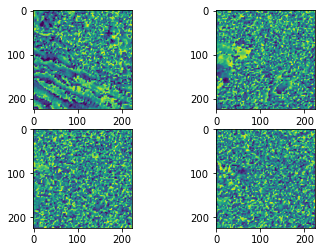

In [8]:
img,label = train_dataset[0]
if (label == 0):
    print("This is class nil")
elif (label == 1):
    print("This is class MOD")
else:
    print("This is class SEV")

Band8 = img[0][:][:]
Band12 = img[1][:][:]
Band13 = img[2][:][:]
Band14 = img[3][:][:]
Band = [Band8,Band12,Band13,Band14]
print(Band8)
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(Band[i-1])
plt.show()


In [ ]:
#Calculate the number of samples in differnet class
train_nil_count = 0   ##591
train_MOD_count = 0   ##839
train_SEV_count = 0   ##324
valid_nil_count = 0   ##192
valid_MOD_count = 0   ##81
valid_SEV_count = 0   ##33

for i in range (0,1754):
    #print(i)
    img, label = train_dataset[i]
    if (label == 0):
        train_nil_count += 1
    elif (label == 1):
        train_MOD_count += 1
    else:
        train_SEV_count += 1
print("train set has %d nil, %d MOD, %d SEV" %(train_nil_count, train_MOD_count, train_SEV_count))

for i in range (0,306):
    #print(i)
    img, label = val_dataset[i]
    if (label == 0):
        valid_nil_count += 1
    elif (label == 1):
        valid_MOD_count += 1
    else:
        valid_SEV_count += 1
print("valid set has %d nil, %d MOD, %d SEV" %(valid_nil_count, valid_MOD_count, valid_SEV_count))

train set has 591 nil, 839 MOD, 324 SEV
valid set has 192 nil, 81 MOD, 33 SEV


## Define Model & Loss 

In [8]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, pin_memory=False)

In [9]:
criterion = nn.CrossEntropyLoss()
#for LDAM
#criterion = LDAMLoss(cls_num_list = label, max_m = 0.5, s = 30, weight = weights).cuda(args.gpu)


In [10]:
class LDAMLoss(nn.Module):
    
    def __init__(self, cls_num_list, max_m=0.5, weight=None, s=30):
        super(LDAMLoss, self).__init__()
        m_list = 1.0 / np.sqrt(np.sqrt(cls_num_list))
        m_list = m_list * (max_m / np.max(m_list))
        m_list = torch.cuda.FloatTensor(m_list)
        self.m_list = m_list
        assert s > 0
        self.s = s
        self.weight = weight

    def forward(self, x, target):
        index = torch.zeros_like(x, dtype=torch.uint8)
        index.scatter_(1, target.data.view(-1, 1), 1)
        
        index_float = index.type(torch.cuda.FloatTensor)
        batch_m = torch.matmul(self.m_list[None, :], index_float.transpose(0,1))
        batch_m = batch_m.view((-1, 1))
        x_m = x - batch_m
    
        output = torch.where(index, x_m, x)
        return F.cross_entropy(self.s*output, target, weight=self.weight)



In [11]:
def LDAMLoss(output, target, n_class_nil, n_class_MOD, n_class_SEV, C):
    loss = 0
    n_class = [n_class_nil, n_class_MOD, n_class_SEV]
      #output_class = output.argmax(dim=1, keepdim=False) #Shape [64], the predict class
    niter = output.shape[0] # 64 for a batch
    for i in range(niter):

        Z_y = output[i][target[i]]
        delta_y = C / (n_class[target[i]] ** (0.25) )
        nominator = torch.exp(Z_y - delta_y)
        if (target[i] == 0):
            dinominator = nominator + torch.exp(output[i][1]) + torch.exp(output[i][2])
        elif (target[i] == 1):
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][2])
        else:
            dinominator = nominator + torch.exp(output[i][0]) + torch.exp(output[i][1])
        loss += (-torch.log(nominator/dinominator))
    return loss



In [12]:
def compute_acc(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=True)
    return preds.eq(targets.view_as(preds)).sum().item() / targets.shape[0]

In [13]:
def performance_eval(outputs, targets):
    preds = outputs.argmax(dim=1, keepdim=False)
    targets = targets.view_as(preds)
    performance_dict = {"NIL":0.0,"MOD":0.0, "SEV":0.0 }
    for i in range(3):
        TP = targets[preds.eq(i)].eq(i).sum().item()
        FP = (~targets[preds.eq(i)].eq(i)).sum().item()
        FN = (~preds[targets.eq(i)].eq(i)).sum().item()
        Precision =  torch.true_divide(TP,(TP + FP))
        Recall = torch.true_divide(TP,(TP + FN))
        F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
        performance_dict[list(performance_dict.keys())[i]] = torch.tensor([Precision,Recall,F1])
    return performance_dict

In [14]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.cnt = 0
        self.TP = torch.tensor([0,0,0])
        self.FP = torch.tensor([0,0,0])
        self.FN = torch.tensor([0,0,0])
        
    def update(self, val, outputs, targets, n=1):
        self.val = val
        self.sum += val * n
        self.cnt += n
        self.avg = self.sum / self.cnt
        preds = outputs.argmax(dim=1, keepdim=True)
        preds = preds.view(-1)
        targets = targets.view(-1)
        for i in range(3):
            self.TP[i] += targets[preds.eq(i)].eq(i).sum().item()
            self.FP[i] += (~targets[preds.eq(i)].eq(i)).sum().item()
            self.FN[i] += (~preds[targets.eq(i)].eq(i)).sum().item()

In [15]:
model = model.cuda()
#criterion = criterion.cuda()

In [16]:
#optimizer = torch.optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [17]:
def train_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(train_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,591,839,324,C = 1.0)
        
        loss.backward()
        optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
        
    return accs
def validate_one_epoch():
    accs = AverageMeter()
    for X, y in tqdm(val_loader, leave=False):
        inputs = X.cuda()
        targets = y.cuda()
        #inputs = X
        #targets = y
        #optimizer.zero_grad()
        # forward
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        loss = LDAMLoss(outputs,targets,192,81,33,C = 0.8)

        #loss.backward()
        #optimizer.step()
        accs.update(compute_acc(outputs, targets), outputs, targets, X.size(0))
    return accs  

In [18]:
best_epoch = -1
best_acc = 0.0
history_acc = []
history_acc_2 = []
best_model_state = model.state_dict()
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

for epoch in tqdm(range(30)):
    for phase in range (0,2):
        if phase == 0:
            model.train()

            accs = train_one_epoch()
            print("epoch {} train acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
            history_acc.append(accs)
            scheduler.step()

        elif phase == 1:
            model.eval()
            accs = validate_one_epoch()
            print("epoch {} valid acc: {:.4f} ".format(epoch, accs.avg))
            class_names = ["NIL","MOD","SEV"]
            for i in range(3):
                Precision =  torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FP[i]))
                Recall = torch.true_divide(accs.TP[i],(accs.TP[i] + accs.FN[i]))
                F1 = torch.true_divide(2*(Precision*Recall),(Precision+Recall))
                print("class {} Precision {:.3f} Recall{:.3f} F1 {:.3f}".format(class_names[i],Precision,Recall,F1))
                #history_acc.append(accs)  
            if accs.avg > best_acc:
                best_acc = accs.avg
                best_epoch = epoch
                best_model_state = model.state_dict()                  
            history_acc_2.append(accs)

print(f'[Info] best val acc: {best_acc:.2%} at {best_epoch+1}th epoch')
      


epoch 0 train acc: 0.5764 
class NIL Precision 0.751 Recall0.433 F1 0.549
class MOD Precision 0.549 Recall0.882 F1 0.677
class SEV Precision 0.227 Recall0.046 F1 0.077


epoch 0 valid acc: 0.5196 
class NIL Precision 0.752 Recall0.536 F1 0.626
class MOD Precision 0.331 Recall0.691 F1 0.448
class SEV Precision nan Recall0.000 F1 nan


epoch 1 train acc: 0.5992 
class NIL Precision 0.714 Recall0.503 F1 0.590
class MOD Precision 0.566 Recall0.897 F1 0.694
class SEV Precision 0.143 Recall0.003 F1 0.006


epoch 1 valid acc: 0.4706 
class NIL Precision 1.000 Recall0.328 F1 0.494
class MOD Precision 0.333 Recall1.000 F1 0.500
class SEV Precision nan Recall0.000 F1 nan


epoch 2 train acc: 0.5935 
class NIL Precision 0.750 Recall0.487 F1 0.591
class MOD Precision 0.559 Recall0.887 F1 0.686
class SEV Precision 0.231 Recall0.028 F1 0.050


epoch 2 valid acc: 0.5980 
class NIL Precision 0.890 Recall0.589 F1 0.708
class MOD Precision 0.391 Recall0.864 F1 0.538
class SEV Precision nan Recall0.000 F1 nan


epoch 3 train acc: 0.6174 
class NIL Precision 0.749 Recall0.560 F1 0.641
class MOD Precision 0.575 Recall0.894 F1 0.700
class SEV Precision 0.286 Recall0.006 F1 0.012


epoch 3 valid acc: 0.6340 
class NIL Precision 0.706 Recall0.802 F1 0.751
class MOD Precision 0.455 Recall0.494 F1 0.473
class SEV Precision nan Recall0.000 F1 nan


epoch 4 train acc: 0.6152 
class NIL Precision 0.750 Recall0.548 F1 0.633
class MOD Precision 0.581 Recall0.888 F1 0.702
class SEV Precision 0.256 Recall0.031 F1 0.055


epoch 4 valid acc: 0.3431 
class NIL Precision 1.000 Recall0.281 F1 0.439
class MOD Precision 0.196 Recall0.272 F1 0.228
class SEV Precision 0.207 Recall0.879 F1 0.335


epoch 5 train acc: 0.6380 
class NIL Precision 0.803 Recall0.585 F1 0.677
class MOD Precision 0.585 Recall0.914 F1 0.713
class SEV Precision 0.545 Recall0.019 F1 0.036


epoch 5 valid acc: 0.5948 
class NIL Precision 0.711 Recall0.703 F1 0.707
class MOD Precision 0.409 Recall0.580 F1 0.480
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 6 train acc: 0.6442 
class NIL Precision 0.795 Recall0.609 F1 0.690
class MOD Precision 0.591 Recall0.915 F1 0.718
class SEV Precision 1.000 Recall0.006 F1 0.012


epoch 6 valid acc: 0.5719 
class NIL Precision 0.665 Recall0.714 F1 0.688
class MOD Precision 0.383 Recall0.444 F1 0.411
class SEV Precision 0.333 Recall0.061 F1 0.103


epoch 7 train acc: 0.6454 
class NIL Precision 0.807 Recall0.623 F1 0.703
class MOD Precision 0.595 Recall0.886 F1 0.712
class SEV Precision 0.429 Recall0.065 F1 0.113


epoch 7 valid acc: 0.5784 
class NIL Precision 0.649 Recall0.760 F1 0.700
class MOD Precision 0.387 Recall0.383 F1 0.385
class SEV Precision 0.000 Recall0.000 F1 nan


epoch 8 train acc: 0.6528 
class NIL Precision 0.798 Recall0.643 F1 0.712
class MOD Precision 0.604 Recall0.901 F1 0.723
class SEV Precision 0.346 Recall0.028 F1 0.051


epoch 8 valid acc: 0.5588 
class NIL Precision 0.642 Recall0.776 F1 0.703
class MOD Precision 0.339 Recall0.235 F1 0.277
class SEV Precision 0.167 Recall0.091 F1 0.118


epoch 9 train acc: 0.6460 
class NIL Precision 0.789 Recall0.628 F1 0.699
class MOD Precision 0.595 Recall0.901 F1 0.717
class SEV Precision 0.462 Recall0.019 F1 0.036


epoch 9 valid acc: 0.5490 
class NIL Precision 0.616 Recall0.786 F1 0.691
class MOD Precision 0.291 Recall0.198 F1 0.235
class SEV Precision 0.167 Recall0.030 F1 0.051


epoch 10 train acc: 0.6574 
class NIL Precision 0.809 Recall0.629 F1 0.708
class MOD Precision 0.605 Recall0.899 F1 0.723
class SEV Precision 0.562 Recall0.083 F1 0.145


epoch 10 valid acc: 0.5686 
class NIL Precision 0.643 Recall0.760 F1 0.697
class MOD Precision 0.368 Recall0.309 F1 0.336
class SEV Precision 0.273 Recall0.091 F1 0.136


epoch 11 train acc: 0.6636 
class NIL Precision 0.826 Recall0.635 F1 0.718
class MOD Precision 0.608 Recall0.900 F1 0.726
class SEV Precision 0.576 Recall0.105 F1 0.178


epoch 11 valid acc: 0.5588 
class NIL Precision 0.640 Recall0.760 F1 0.695
class MOD Precision 0.361 Recall0.272 F1 0.310
class SEV Precision 0.176 Recall0.091 F1 0.120


epoch 12 train acc: 0.6568 
class NIL Precision 0.799 Recall0.638 F1 0.709
class MOD Precision 0.606 Recall0.882 F1 0.718
class SEV Precision 0.583 Recall0.108 F1 0.182


epoch 12 valid acc: 0.5719 
class NIL Precision 0.642 Recall0.776 F1 0.703
class MOD Precision 0.365 Recall0.284 F1 0.319
class SEV Precision 0.273 Recall0.091 F1 0.136


epoch 13 train acc: 0.6659 
class NIL Precision 0.797 Recall0.677 F1 0.732
class MOD Precision 0.618 Recall0.878 F1 0.726
class SEV Precision 0.517 Recall0.096 F1 0.161


epoch 13 valid acc: 0.5752 
class NIL Precision 0.644 Recall0.781 F1 0.706
class MOD Precision 0.383 Recall0.284 F1 0.326
class SEV Precision 0.231 Recall0.091 F1 0.130


epoch 14 train acc: 0.6545 
class NIL Precision 0.780 Recall0.655 F1 0.712
class MOD Precision 0.611 Recall0.869 F1 0.718
class SEV Precision 0.492 Recall0.099 F1 0.165


epoch 14 valid acc: 0.5719 
class NIL Precision 0.643 Recall0.771 F1 0.701
class MOD Precision 0.364 Recall0.296 F1 0.327
class SEV Precision 0.300 Recall0.091 F1 0.140


epoch 15 train acc: 0.6631 
class NIL Precision 0.830 Recall0.643 F1 0.724
class MOD Precision 0.611 Recall0.900 F1 0.728
class SEV Precision 0.459 Recall0.086 F1 0.145


epoch 15 valid acc: 0.5686 
class NIL Precision 0.637 Recall0.786 F1 0.704
class MOD Precision 0.368 Recall0.259 F1 0.304
class SEV Precision 0.167 Recall0.061 F1 0.089


epoch 16 train acc: 0.6619 
class NIL Precision 0.821 Recall0.658 F1 0.731
class MOD Precision 0.610 Recall0.894 F1 0.725
class SEV Precision 0.440 Recall0.068 F1 0.118


epoch 16 valid acc: 0.5719 
class NIL Precision 0.643 Recall0.771 F1 0.701
class MOD Precision 0.375 Recall0.296 F1 0.331
class SEV Precision 0.250 Recall0.091 F1 0.133


epoch 17 train acc: 0.6750 
class NIL Precision 0.827 Recall0.665 F1 0.737
class MOD Precision 0.620 Recall0.905 F1 0.736
class SEV Precision 0.582 Recall0.099 F1 0.169


epoch 17 valid acc: 0.5686 
class NIL Precision 0.636 Recall0.781 F1 0.701
class MOD Precision 0.361 Recall0.272 F1 0.310
class SEV Precision 0.222 Recall0.061 F1 0.095


epoch 18 train acc: 0.6745 
class NIL Precision 0.824 Recall0.675 F1 0.742
class MOD Precision 0.622 Recall0.895 F1 0.734
class SEV Precision 0.524 Recall0.102 F1 0.171


epoch 18 valid acc: 0.5752 
class NIL Precision 0.637 Recall0.786 F1 0.704
class MOD Precision 0.377 Recall0.284 F1 0.324
class SEV Precision 0.250 Recall0.061 F1 0.098


epoch 19 train acc: 0.6562 
class NIL Precision 0.784 Recall0.646 F1 0.709
class MOD Precision 0.613 Recall0.878 F1 0.722
class SEV Precision 0.500 Recall0.099 F1 0.165


epoch 19 valid acc: 0.5686 
class NIL Precision 0.634 Recall0.786 F1 0.702
class MOD Precision 0.355 Recall0.272 F1 0.308
class SEV Precision 0.167 Recall0.030 F1 0.051


epoch 20 train acc: 0.6688 
class NIL Precision 0.827 Recall0.655 F1 0.731
class MOD Precision 0.615 Recall0.908 F1 0.733
class SEV Precision 0.522 Recall0.074 F1 0.130


epoch 20 valid acc: 0.5784 
class NIL Precision 0.644 Recall0.781 F1 0.706
class MOD Precision 0.381 Recall0.296 F1 0.333
class SEV Precision 0.300 Recall0.091 F1 0.140


epoch 21 train acc: 0.6648 
class NIL Precision 0.810 Recall0.665 F1 0.730
class MOD Precision 0.616 Recall0.894 F1 0.729
class SEV Precision 0.451 Recall0.071 F1 0.123


epoch 21 valid acc: 0.5621 
class NIL Precision 0.632 Recall0.786 F1 0.701
class MOD Precision 0.339 Recall0.247 F1 0.286
class SEV Precision 0.125 Recall0.030 F1 0.049


epoch 22 train acc: 0.6574 
class NIL Precision 0.809 Recall0.645 F1 0.718
class MOD Precision 0.607 Recall0.887 F1 0.721
class SEV Precision 0.491 Recall0.086 F1 0.147


epoch 22 valid acc: 0.5654 
class NIL Precision 0.634 Recall0.786 F1 0.702
class MOD Precision 0.357 Recall0.247 F1 0.292
class SEV Precision 0.167 Recall0.061 F1 0.089


epoch 23 train acc: 0.6659 
class NIL Precision 0.820 Recall0.668 F1 0.736
class MOD Precision 0.612 Recall0.893 F1 0.726
class SEV Precision 0.490 Recall0.074 F1 0.129


epoch 23 valid acc: 0.5784 
class NIL Precision 0.644 Recall0.781 F1 0.706
class MOD Precision 0.375 Recall0.296 F1 0.331
class SEV Precision 0.333 Recall0.091 F1 0.143


epoch 24 train acc: 0.6613 
class NIL Precision 0.813 Recall0.668 F1 0.734
class MOD Precision 0.611 Recall0.886 F1 0.723
class SEV Precision 0.431 Recall0.068 F1 0.117


epoch 24 valid acc: 0.5686 
class NIL Precision 0.634 Recall0.786 F1 0.702
class MOD Precision 0.356 Recall0.259 F1 0.300
class SEV Precision 0.222 Recall0.061 F1 0.095


epoch 25 train acc: 0.6648 
class NIL Precision 0.814 Recall0.653 F1 0.725
class MOD Precision 0.611 Recall0.894 F1 0.726
class SEV Precision 0.566 Recall0.093 F1 0.159


epoch 25 valid acc: 0.5719 
class NIL Precision 0.641 Recall0.771 F1 0.700
class MOD Precision 0.364 Recall0.296 F1 0.327
class SEV Precision 0.333 Recall0.091 F1 0.143


epoch 26 train acc: 0.6699 
class NIL Precision 0.818 Recall0.663 F1 0.733
class MOD Precision 0.617 Recall0.895 F1 0.730
class SEV Precision 0.561 Recall0.099 F1 0.168


epoch 26 valid acc: 0.5784 
class NIL Precision 0.646 Recall0.771 F1 0.703
class MOD Precision 0.382 Recall0.321 F1 0.349
class SEV Precision 0.333 Recall0.091 F1 0.143


epoch 27 train acc: 0.6608 
class NIL Precision 0.812 Recall0.657 F1 0.726
class MOD Precision 0.609 Recall0.889 F1 0.723
class SEV Precision 0.481 Recall0.077 F1 0.133


epoch 27 valid acc: 0.5621 
class NIL Precision 0.634 Recall0.776 F1 0.698
class MOD Precision 0.355 Recall0.272 F1 0.308
class SEV Precision 0.111 Recall0.030 F1 0.048


epoch 28 train acc: 0.6710 
class NIL Precision 0.822 Recall0.673 F1 0.740
class MOD Precision 0.618 Recall0.897 F1 0.732
class SEV Precision 0.500 Recall0.080 F1 0.138


epoch 28 valid acc: 0.5719 
class NIL Precision 0.642 Recall0.776 F1 0.703
class MOD Precision 0.364 Recall0.296 F1 0.327
class SEV Precision 0.250 Recall0.061 F1 0.098


epoch 29 train acc: 0.6619 
class NIL Precision 0.809 Recall0.668 F1 0.732
class MOD Precision 0.614 Recall0.875 F1 0.722
class SEV Precision 0.451 Recall0.099 F1 0.162


epoch 29 valid acc: 0.5654 
class NIL Precision 0.632 Recall0.786 F1 0.701
class MOD Precision 0.345 Recall0.247 F1 0.288
class SEV Precision 0.222 Recall0.061 F1 0.095

[Info] best val acc: 63.40% at 4th epoch


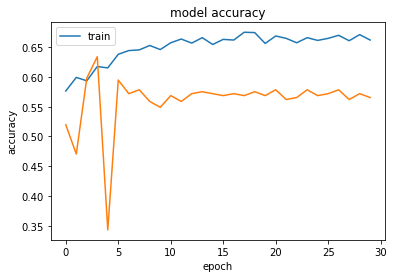

In [19]:
accuracy = []
accuracy_2 = []

for accs in history_acc:
    accuracy.append(accs.avg)
for accs in history_acc_2:
    accuracy_2.append(accs.avg)
plt.plot(range(30),accuracy)
plt.plot(range(30),accuracy_2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
model.eval()
for X, y in tqdm(val_loader, leave=False):
    inputs = X.cuda()
    outputs = model(inputs)
    print(outputs.shape)
    print(y.shape)
    print("y actual:",y)
    print(outputs)
    #print(outputs.argmax(dim=1, keepdim=True))
    acc = compute_acc(outputs.cpu(), y)
    print(f'Test Acc: {acc}')

torch.Size([64, 3])
torch.Size([64])
y actual: tensor([1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 2, 0, 1, 0, 1,
        0, 1, 0, 2, 0, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 1, 2, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 0, 0, 0, 1, 2, 0])
tensor([[ -1.7492,   4.7673,  -3.2130],
        [ -1.1726,   2.3296,  -1.3206],
        [  7.7604,  -2.3970,  -4.4281],
        [ -1.9165,   4.6665,  -2.8588],
        [ -1.5419,   2.6405,  -0.8664],
        [  7.0444,   1.0606,  -6.7852],
        [ -4.5250,   2.9591,   1.4555],
        [  5.5719,  -1.2853,  -3.3640],
        [  3.5251,  -0.7187,  -2.6303],
        [ -0.6647,   3.1601,  -2.6787],
        [ -2.1094,   0.1991,   1.6834],
        [ -3.9049,   7.5359,  -3.8945],
        [  6.3205,  -1.3224,  -3.9261],
        [  4.1235,  -0.9173,  -2.5986],
        [ -4.4681,   4.6649,  -0.5989],
        [  0.8039,   1.2321,  -2.0851],
        [  8.0013,  -0.4920,  -7.1257],
        [  0.1916,   0.7504,  -0.5899],
        [ -4.972

In [ ]:
print(outputs.shape[0])
output_class = outputs.argmax(dim=1, keepdim=False)
print(output_class)

50
tensor([0, 1, 1, 0, 0, 1, 2, 2, 1, 2, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        2, 1, 2, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0,
        1, 0], device='cuda:0')


In [ ]:
print(y.shape)

torch.Size([50])
